In [1]:
import numpy as np
from matplotlib import pyplot

In [2]:
def flux(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

In [3]:
def upwind(psi, i, C):
    return psi[i] - flux(psi[i    ], psi[i+one], C[i]) + \
                    flux(psi[i-one], psi[i    ], C[i-one])

In [230]:
def C_corr(C, nx, psi):
    j = slice(0, nx-1)
    return (abs(C[j]) - C[j]**2) * (psi[j+one] - psi[j]) / (psi[j+one] + psi[j] + 1e-10)

In [231]:
class shift:
    def __radd__(self, i): 
        return slice(i.start+1, i.stop+1)
    def __rsub__(self, i): 
        return slice(i.start-1, i.stop-1)
one = shift()

In [316]:
def psi_0(x):
    a = 25
    return np.where(np.abs(x)<np.pi/2*a, np.cos(x/a)**2, 0)

In [317]:
def plot(x, psi_0, psi_T_a, psi_T_n, n_corr_it):
    pyplot.step(x, psi_0, label='initial', where='mid')
    pyplot.step(x, psi_T_a, label='analytical', where='mid')
    pyplot.step(x, psi_T_n, label='numerical', where='mid')
    pyplot.grid()
    pyplot.legend()
    pyplot.title(f'MPDATA {n_corr_it} corrective iterations')
    pyplot.show()

In [ ]:
def solve(nx=75, nt=50, n_corr_it=2, make_plot=False):
    T = 50
    x_min, x_max = -50, 250
    C = .1

In [407]:
    dt =  T / nt
    x, dx = np.linspace(x_min, x_max, nx, endpoint=False, retstep=True)
    v = C / dt * dx
    assert C <= 1
    i = slice(1, nx-2)
    C_phys = np.full(nx-1, C)
    psi = psi_0(x)
    
    for _ in range(nt):
        psi[i] = upwind(psi, i, C_phys)
        C_iter = C_phys
        for it in range(n_corr_it):
            C_iter = C_corr(C_iter, nx, psi)
            psi[i] = upwind(psi, i, C_iter)
    
    psi_true = psi_0(x-v*nt*dt)
    err = np.sqrt(sum(pow(psi-psi_true, 2)) / nt / nx)
    if make_plot:
        plot(x, psi_0(x), psi_T_a=psi_true, psi_T_n=psi, n_corr_it=n_corr_it)
    return dx, dt, err

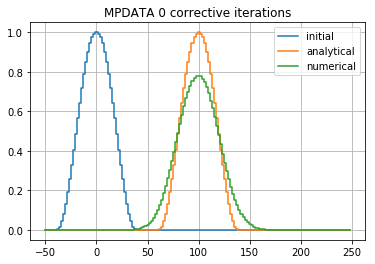

(2.0, 0.1, 0.003170131814196489)

In [404]:
solve(nx=150, nt=500, n_corr_it=0, make_plot=True)

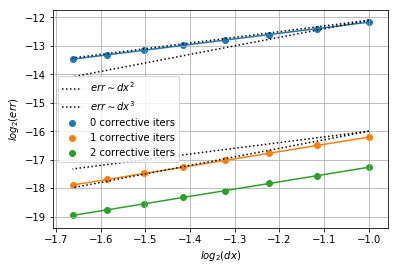

In [406]:
for n_it in [0,1,2]:
    data = {'x':[], 'y':[]}
    for nx in range(600,1000,50):
        dx, dt, err = solve(nx=nx, nt=300, n_corr_it=n_it)
        data['x'].append(np.log2(dx))
        data['y'].append(np.log2(err))
    pyplot.scatter(data['x'], data['y'], label=f"{n_it} corrective iters")
    pyplot.plot(data['x'], data['y'])
    
def line(k, offset, label=False):
    pyplot.plot(
        data['x'], 
        k*np.array(data['x']) + offset, 
        label=f'$err \sim dx^{k}$' if label else '', 
        linestyle=':',
        color='black'
    )
line(k=2, offset=-10.1, label=True)
line(k=3, offset=-9.1, label=True)

line(k=2, offset=-14)
line(k=3, offset=-13)
    
pyplot.legend()
pyplot.gca().set_xlabel('$log_2(dx)$')
pyplot.gca().set_ylabel('$log_2(err)$')
pyplot.grid()